In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, minmax_scale

import geopandas as gpd
import json
import h3
import folium
import osmnx as ox
from shapely import wkt
from folium.plugins import HeatMap
from shapely.geometry import Polygon

from geopy.geocoders import Nominatim
from transliterate import translit

from multiprocessing import Pool as PoolSklearn
import tqdm
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import train_test_split as tts

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

In [101]:
df_train = pd.read_csv('train_initial.csv')

df_trai = pd.read_csv('train.csv')

In [102]:
df_train.shape

(6258, 7)

In [103]:
df_train.isna().sum()

id             0
atm_group      0
address        0
address_rus    0
lat            0
long           0
target         0
dtype: int64

In [98]:
df_train[df_train.isnull()] = df_trai

In [99]:
df_train = df_train.dropna(subset=['lat', 'long'])
df_train.shape

(6258, 7)

In [100]:
df_train.to_csv('train_initial.csv', index=False)

In [100]:
# df_train = df_train.dropna()
# df_train = df_train.reset_index(drop=True)

In [128]:
%%time
geolocator = Nominatim(user_agent='your_app_name')

coordinates = np.array([list(df_train.loc[idx][['lat', 'long']].tolist()) for idx in range(len(df_train))])

addresses = []

for coordinate in coordinates:
    addresses.append(geolocator.reverse(coordinate))

CPU times: user 18.7 s, sys: 1.71 s, total: 20.4 s
Wall time: 52min 43s


In [189]:
def get_area_features(df:pd.DataFrame) -> pd.DataFrame:
    addresses = []
    cities, city_areas, city_district, federal_district  = [], [], [], []

    geolocator = Nominatim(user_agent='your_app_name')
    coordinates = np.array([list(df.loc[idx][['lat', 'long']].tolist()) for idx in range(len(df))])
    
    for coordinate in coordinates:
        addresses.append(geolocator.reverse(coordinate))

    for add in addresses:
        try:
            cities.append(add.raw['address']['city'])
        except:
            cities.append('')
        try:
            city_areas.append(add.raw['address']['county'])
        except:
            city_areas.append('')
        try:
            city_district.append(add.raw['address']['quarter'])
        except:
            city_district.append('')
        try:
            federal_district.append(add.raw['address']['state'])
        except:
            federal_district.append('')

        df['city'] = cities
        df['city_areas'] = city_areas
        df['city_district'] = city_district
        df['federal_district'] = federal_district

        return df

In [ ]:
get_area_features(df_train)

In [104]:
need_obj = [
    {'amenity' : 'fast_food'},
    {'amenity' : 'cafe'},
    {'amenity' : 'bar'},
    {'amenity' : 'pub'},
    {'amenity' : 'restaurant'},
    {'amenity' : 'college'},
    {'amenity' : 'kindergarten'},
    {'amenity' : 'library'},
    {'amenity' : 'training'},
    {'amenity' : 'school'},
    {'amenity' : 'traffic_park'},
    {'amenity' : 'university'},
    {'amenity' : 'bicycle_parking'},
    {'amenity' : 'bus_station'},
    {'amenity' : 'car_sharing'},
    {'amenity' : 'fuel'},
    {'amenity' : 'parking'},
    {'amenity' : 'taxi'},
    {'amenity' : 'atm'},
    {'amenity' : 'payment_terminal'},
    {'amenity' : 'bank'},
    {'amenity' : 'bureau_de_change'},
    {'amenity' : 'money_transfer'},
    {'amenity' : 'payment_centre'},
    {'amenity' : 'clinic'},
    {'amenity' : 'hospital'},
    {'amenity' : 'pharmacy'},
    {'amenity' : 'social_facility'},
    {'amenity' : 'cinema'},
    {'amenity' : 'community_centre'},
    {'amenity' : 'conference_centre'},
    {'amenity' : 'events_venue'},
    {'amenity' : 'exhibition_centre'},
    {'amenity' : 'nightclub'},
    {'amenity' : 'social_centre'},
    {'amenity' : 'theatre'},
    {'amenity' : 'police'},
    {'amenity' : 'post_box'},
    {'amenity' : 'post_office'},
    {'amenity' : 'toilets'},
    {'amenity' : 'internet_cafe'},
    {'amenity' : 'marketplace'},
    {'building' : 'apartments, detached'},
    {'building' : 'detached'},
    {'building' : 'hotel'},
    {'building' : 'residential'},
    {'building' : 'commercial'},
    {'building' : 'industrial'},
    {'building' : 'kiosk'},
    {'building' : 'office'},
    {'building' : 'retail'},
    {'building' : 'supermarket'},
    {'building' : 'warehouse'},
    {'building' : 'religious'},
    {'building' : 'church'},
    {'building' : 'government'},
    {'building' : 'hospital'},
    {'railway' : 'station'},
    {'railway' : 'tram'},
    {'public_transport' : 'platform'},
    {'boundary' : 'administrative'}
]

In [105]:
import json

with open('objects.json', 'w') as fp:
    json.dump(need_obj, fp)

In [106]:
with open('objects.json') as json_file:
    data = json.load(json_file)

In [107]:
data

[{'amenity': 'fast_food'},
 {'amenity': 'cafe'},
 {'amenity': 'bar'},
 {'amenity': 'pub'},
 {'amenity': 'restaurant'},
 {'amenity': 'college'},
 {'amenity': 'kindergarten'},
 {'amenity': 'library'},
 {'amenity': 'training'},
 {'amenity': 'school'},
 {'amenity': 'traffic_park'},
 {'amenity': 'university'},
 {'amenity': 'bicycle_parking'},
 {'amenity': 'bus_station'},
 {'amenity': 'car_sharing'},
 {'amenity': 'fuel'},
 {'amenity': 'parking'},
 {'amenity': 'taxi'},
 {'amenity': 'atm'},
 {'amenity': 'payment_terminal'},
 {'amenity': 'bank'},
 {'amenity': 'bureau_de_change'},
 {'amenity': 'money_transfer'},
 {'amenity': 'payment_centre'},
 {'amenity': 'clinic'},
 {'amenity': 'hospital'},
 {'amenity': 'pharmacy'},
 {'amenity': 'social_facility'},
 {'amenity': 'cinema'},
 {'amenity': 'community_centre'},
 {'amenity': 'conference_centre'},
 {'amenity': 'events_venue'},
 {'amenity': 'exhibition_centre'},
 {'amenity': 'nightclub'},
 {'amenity': 'social_centre'},
 {'amenity': 'theatre'},
 {'ameni

In [18]:
def get_obj(point, tag, city):
    try:
        gdf = ox.features_from_point(
            center_point=point,
            tags=tag,
            dist=100
            ).reset_index()
        gdf['city'] = np.full(len(gdf), city)
        gdf['object'] = np.full(len(gdf), list(tag.keys())[0])
        gdf['type'] = np.full(len(gdf), tag[list(tag.keys())[0]])
        gdf['point'] = np.full(len(gdf), str(point))
        gdf = gdf[['city', 'point', 'object', 'type', 'geometry']]
    except:
        city_lst = city
        object_lst = list(tag.keys())[0]
        type_lst = tag[list(tag.keys())[0]]
        point_lst = str(point)
        geometry_lst = np.nan
        gdf = pd.DataFrame(
            {
                'city':city_lst,
                'object':object_lst,
                'type':type_lst,
                'point':point_lst,
                'geometry':geometry_lst
                },
            index=[0]
            )
        gdf = gdf[['city', 'point', 'object', 'type', 'geometry']]

    return gdf

In [154]:
%%time

gdfs = []
for idx in range(len(df_trai)):
    point = tuple(df_trai.loc[idx][['lat', 'long']].tolist())
    city = df_trai.loc[idx]['city']
    for tag in need_obj:
        gdfs.append(get_obj(point, tag, city))
    print(point)
    print(len(gdfs))
    break

(46.940995, 142.738319)
57
CPU times: user 3.72 s, sys: 143 ms, total: 3.86 s
Wall time: 4.03 s


In [157]:
type(gdfs[0])

pandas.core.frame.DataFrame

In [20]:
data_poi = pd.concat(gdfs)

/var/folders/wt/dr3521jx3dlf8ys18db161rc0000gn/T/ipykernel_49086/2367770371.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_poi = pd.concat(gdfs)


In [23]:
data_poi.to_csv('df_train_full.csv', index=False)

In [25]:
data_poi

,city,point,object,type,geometry
0,Южно-Сахалинск,"(46.940995, 142.738319)",amenity,fast_food,None
0,Южно-Сахалинск,"(46.940995, 142.738319)",amenity,cafe,None
0,Южно-Сахалинск,"(46.940995, 142.738319)",amenity,bar,None
0,Южно-Сахалинск,"(46.940995, 142.738319)",amenity,pub,None
0,Южно-Сахалинск,"(46.940995, 142.738319)",amenity,restaurant,None
...,...,...,...,...,...
0,село Кижинга,"(51.848725, 109.905102)",building,warehouse,None
0,село Кижинга,"(51.848725, 109.905102)",building,religious,None
0,село Кижинга,"(51.848725, 109.905102)",building,church,None
0,село Кижинга,"(51.848725, 109.905102)",building,government,None


In [26]:
data_poi_agg = data_poi.groupby(['point','object','type'], as_index = False).agg({'geometry':'count'})

In [39]:
len(data_poi_agg['point'].unique())

4553

In [34]:
pd.pivot_table(data_poi_agg, index=["point"], columns=['type'], aggfunc=[np.sum], values=['geometry']).reset_index()

/var/folders/wt/dr3521jx3dlf8ys18db161rc0000gn/T/ipykernel_49086/3634488213.py:1: FutureWarning: The provided callable <function sum at 0x7f8bda85e9e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pd.pivot_table(data_poi_agg, index=["point"], columns=['type'], aggfunc=[np.sum], values=['geometry']).reset_index()


point                  sum               \
                                          geometry                
type                          apartments, detached atm bank bar   
0        (42.05708, 48.30023)                    0   0    1   0   
1      (42.077207, 48.288552)                    0   0    0   0   
2     (42.648627, 131.080657)                    0   0    0   0   
3     (42.713429, 130.778572)                    0   0    1   0   
4      (42.77617, 132.853455)                    0   2    0   0   
...                       ...                  ...  ..  ...  ..   
4548   (69.407878, 30.222219)                    0   0    0   0   
4549   (69.426173, 30.837933)                    0   0    0   0   
4550   (69.483491, 88.388241)                    0   0    0   0   
4551   (69.490557, 88.383354)                    0   2    0   0   
4552   (69.491912, 88.409073)                    0   0    0   0   

                                                                    ...  \
                                                                    ...   
type bicycle_parking bureau_de_change bus_station cafe car_sharing  ...   
0                  0                0           0    0           0  ...   
1                  0                0           0    0           0  ...   
2                  0                0           0    0           0  ...   
3                  0                0           0    0           0  ...   
4                  0                0           0    0           0  ...   
...              ...              ...         ...  ...         ...  ...   
4548               0                0           0    0           0  ...   
4549               0                0           0    0           0  ...   
4550               0                0           0    2           0  ...   
4551               0                0           0    0           0  ...   
4552               0                0           0    1           0  ...   

                                                                     \
                                                                      
type social_centre social_facility supermarket taxi theatre toilets   
0                0               0           0    0       0       0   
1                0               0           0    0       0       0   
2                0               0           0    0       0       0   
3                0               0           0    0       0       0   
4                0               0           0    0       0       0   
...            ...             ...         ...  ...     ...     ...   
4548             0               0           0    0       0       0   
4549             0               0           0    0       0       0   
4550             0               0           0    0       0       0   
4551             0               0           0    0       0       0   
4552             0               0           0    0       0       0   

                                                 
                                                 
type traffic_park training university warehouse  
0               0        0          0         0  
1               0        0          0         0  
2               0        0          0         0  
3               0        0          0         0  
4               0        0          0         0  
...           ...      ...        ...       ...  
4548            0        0          0         0  
4549            0        0          0         0  
4550            0        0          0         0  
4551            0        0          0         0  
4552            0        0          0         0  

[4553 rows x 57 columns]

In [35]:
df_train

,id,atm_group,address,address_rus,lat,long,target,city,region
0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500,Южно-Сахалинск,Сахалинская область
1,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710,Южно-Сахалинск,Сахалинская область
2,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540,Сахалинская область,Сахалинская область
3,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035,Москва,Москва
4,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277,Норильск,Красноярский край
...,...,...,...,...,...,...,...,...,...
5952,4402.0,8083.0,"FEDORA POPOVA, 14 Yakutsk","улица Федора Попова, 14, Якутск, Республика Са...",62.045259,129.748896,0.207916,Якутск,Республика Саха (Якутия)
5953,4421.0,8083.0,"STROITELEY, 43 Novokuznetsk","проспект Строителей, 43, Новокузнецк, Кемеровс...",53.769459,87.117251,0.062220,Новокузнецк,Кемеровская область
5954,4422.0,8083.0,"Rublevskoye sh, 62 Moskva","Рублёвское шоссе, 62, Москва, Россия, 121609",55.766212,37.380875,0.108743,Москва,Москва
5955,4426.0,8083.0,"EFANOVA, 22 Zyryanskoye","улица Ефанова, 22, село Зырянское, Зырянский р...",56.838223,86.640829,0.148938,село Зырянское,Томская область


In [125]:
ox.geometries_from_point(center_point=(55.805827, 37.515146), tags={'amenity' : 'fast_food'}, dist=100)

<ipython-input-125-e455a9dca5d1>:1: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.geometries_from_point(center_point=(55.805827, 37.515146), tags={'amenity' : 'fast_food'}, dist=100)


amenity      cuisine                  name  \
element_type osmid                                                       
node         4367754396   fast_food  coffee_shop          Кофе с собой   
             5151924587   fast_food       burger           Бургер Кинг   
             5345234062   fast_food  coffee_shop       Brooklyn coffee   
             10864902639  fast_food  coffee_shop      One Price Coffee   
             11368500016  fast_food       potato       Крошка Картошка   
             11397537900  fast_food          NaN  Eazzy Pizza & Gelato   

                                                              opening_hours  \
element_type osmid                                                            
node         4367754396                Mo-Fr 07:00-22:00; Sa-Su 07:30-22:00   
             5151924587                                   Mo-Su 10:00-21:50   
             5345234062                                   Mo-Su 10:00-20:00   
             10864902639  Mo-Fr 07:00-22:00; Sa 08:00-22:00; Su 08:00-21:00   
             11368500016                                  Mo-Su 10:00-21:00   
             11397537900                                               24/7   

                                   phone takeaway  \
element_type osmid                                  
node         4367754396   +7 999 1945020     only   
             5151924587              NaN      yes   
             5345234062              NaN     only   
             10864902639             NaN      yes   
             11368500016             NaN      NaN   
             11397537900             NaN      NaN   

                                                           website  \
element_type osmid                                                   
node         4367754396   https://www.instagram.com/coffe_s_soboi/   
             5151924587                                        NaN   
             5345234062                                        NaN   
             10864902639                                       NaN   
             11368500016                                       NaN   
             11397537900                                       NaN   

                                           geometry             brand  \
element_type osmid                                                      
node         4367754396   POINT (37.51614 55.80529)               NaN   
             5151924587   POINT (37.51513 55.80588)       Бургер Кинг   
             5345234062   POINT (37.51428 55.80574)               NaN   
             10864902639  POINT (37.51596 55.80571)  One Price Coffee   
             11368500016  POINT (37.51481 55.80598)               NaN   
             11397537900  POINT (37.51644 55.80521)               NaN   

                             brand:en  ... brand:wikipedia  \
element_type osmid                     ...                   
node         4367754396           NaN  ...             NaN   
             5151924587   Burger King  ...  en:Burger King   
             5345234062           NaN  ...             NaN   
             10864902639          NaN  ...             NaN   
             11368500016          NaN  ...             NaN   
             11397537900          NaN  ...             NaN   

                                   contact:email   contact:phone  \
element_type osmid                                                 
node         4367754396                      NaN             NaN   
             5151924587   FeedBack@burgerking.ru  +7 495 5445000   
             5345234062                      NaN             NaN   
             10864902639  b2b@onepricecoffee.com  +7 495 0153150   
             11368500016                     NaN  +7 985 2000489   
             11397537900                     NaN  +7 909 9529419   

                                      contact:website internet_access  \
element_type osmid                                                      
node         4367754396                    

In [ ]:
data_poi

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,city,object,type,geometry,lat,lon
0,Москва,building,apartments,"POLYGON ((37.22605 55.51590, 37.22610 55.51601...",55.515882,37.226577
1,Москва,building,apartments,"POLYGON ((37.22435 55.51618, 37.22440 55.51629...",55.516155,37.224920
2,Москва,building,apartments,"POLYGON ((37.22453 55.51664, 37.22459 55.51675...",55.516603,37.225122
3,Москва,building,apartments,"POLYGON ((37.22477 55.51708, 37.22482 55.51719...",55.517047,37.225350
4,Москва,building,apartments,"POLYGON ((37.29724 55.48611, 37.29828 55.48612...",55.486054,37.297759
...,...,...,...,...,...,...
22404,Москва,amenity,bench,"POLYGON ((37.67871 55.58776, 37.67872 55.58776...",55.587766,37.678725
22405,Москва,amenity,bench,"LINESTRING (37.45122 55.52537, 37.45122 55.52527)",55.525321,37.451219
22406,Москва,amenity,bench,"POLYGON ((37.69821 55.58234, 37.69818 55.58233...",55.582308,37.698235
22407,Москва,amenity,bench,"POLYGON ((37.69798 55.58223, 37.69795 55.58221...",55.582192,37.698005


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    pd.get_dummies(df_train).drop(['id', 'target'], axis=1),
    pd.get_dummies(df_train)['target'],
    test_size=0.2,
    random_state=13)

In [ ]:
model = LinearRegression()

model.fit(X_train, y_train)
predicts = model.predict(X_test)

In [ ]:
mean_absolute_error(y_test, predicts)

80766.8346904284

In [49]:
df = pd.read_csv('train.csv')
df = df.dropna(subset=['lat', 'long'])
df = df.reset_index(drop=True)

In [50]:
df['target'] = minmax_scale(df['target'], feature_range=(1, 5), axis=0)
df['target'] = df['target'].apply(np.round).apply(int)

In [51]:
df['target'].value_counts()

target
2    2809
3    1846
4     660
1     552
5     391
Name: count, dtype: int64

In [52]:
num_features = [
    'metro', 'local_area', 'area_population', 
    'sustenance', 'education', 'fuel', 'service', 
    'parking', 'atm', 'bank','bureau_de_change', 
    'outpatient_medical_facilities',    
    'inplace_medical_facilities', 'pharmacy', 
    'veterinary', 'entertainment',       
    'entertainment_for_adults', 'administrative_buildings', 
    'police', 'fire_station', 'post_office', 
    'grave_yard', 'marketplace', 'monastery',
    'place_of_worship', 'public_transport_stop_position', 'alcohol_shop',
    'food_shop', 'supermarket', 'mall', 'wholesale', 'clothing_shop',
    'discount_store', 'beauty_store', 'hardware_store', 'interior_store',
    'electronics_store', 'sport_store', 'auto_moto_store',
    'car_parts_store', 'hobbies_store', 'books_store', 'hotel', 'museum'
]

cat_features=[
    'atm_group','city', 'city_area', 
    'city_district', 'federal_district',
    'region_type', 'capital'
]

In [53]:
df[cat_features] = df[cat_features].fillna('no_data')
df['capital'] = df['capital'].apply(str)
df['atm_group'] = df['atm_group'].apply(str)
df = df.fillna(0)

In [54]:
def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        iterations=25000,
        learning_rate=0.01,
        eval_metric='AUC',
        early_stopping_rounds=30,
        use_best_model= True,
        task_type='CPU',
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=100,
    )

In [55]:
df.reset_index(drop=True, inplace=True)

df_train_val = df.drop(['id', 'address', 'address_rus', 'lat', 'long','target'], axis=1)
y_train_val = df['target']
X_train, X_val, y_train, y_val = tts(df_train_val, y_train_val, shuffle=True, stratify=y_train_val, train_size=0.8)

In [56]:
train_pool = Pool(
    X_train, y_train,
    cat_features=[
        'atm_group', 'city', 'city_area', 
        'city_district', 'federal_district',
        'region_type', 'capital'
        ]
)

validation_pool = Pool(
    X_val, y_val,
    cat_features=[
        'atm_group', 'city', 'city_area', 
        'city_district', 'federal_district',
        'region_type', 'capital'
        ]
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

model = fit_model(train_pool, validation_pool)

Train dataset shape: (5006, 51)

0:	test: 0.8153101	best: 0.8153101 (0)	total: 32.8ms	remaining: 13m 39s
100:	test: 0.8712184	best: 0.8712184 (100)	total: 2.3s	remaining: 9m 27s
200:	test: 0.8818919	best: 0.8818919 (200)	total: 4.68s	remaining: 9m 37s
300:	test: 0.8880486	best: 0.8880486 (300)	total: 7.08s	remaining: 9m 40s
400:	test: 0.8915303	best: 0.8915675 (394)	total: 9.68s	remaining: 9m 54s
500:	test: 0.8938950	best: 0.8938950 (500)	total: 12.1s	remaining: 9m 49s
600:	test: 0.8956013	best: 0.8956338 (599)	total: 14.5s	remaining: 9m 48s
700:	test: 0.8964800	best: 0.8965389 (687)	total: 16.9s	remaining: 9m 44s
800:	test: 0.8970436	best: 0.8970436 (800)	total: 19.3s	remaining: 9m 43s
900:	test: 0.8977757	best: 0.8978565 (898)	total: 21.9s	remaining: 9m 46s
1000:	test: 0.8985357	best: 0.8985519 (997)	total: 24.5s	remaining: 9m 48s
1100:	test: 0.8992505	best: 0.8992646 (1099)	total: 27.2s	remaining: 9m 50s
1200:	test: 0.8996020	best: 0.8996168 (1198)	total: 29.8s	remaining: 9m 51s
130

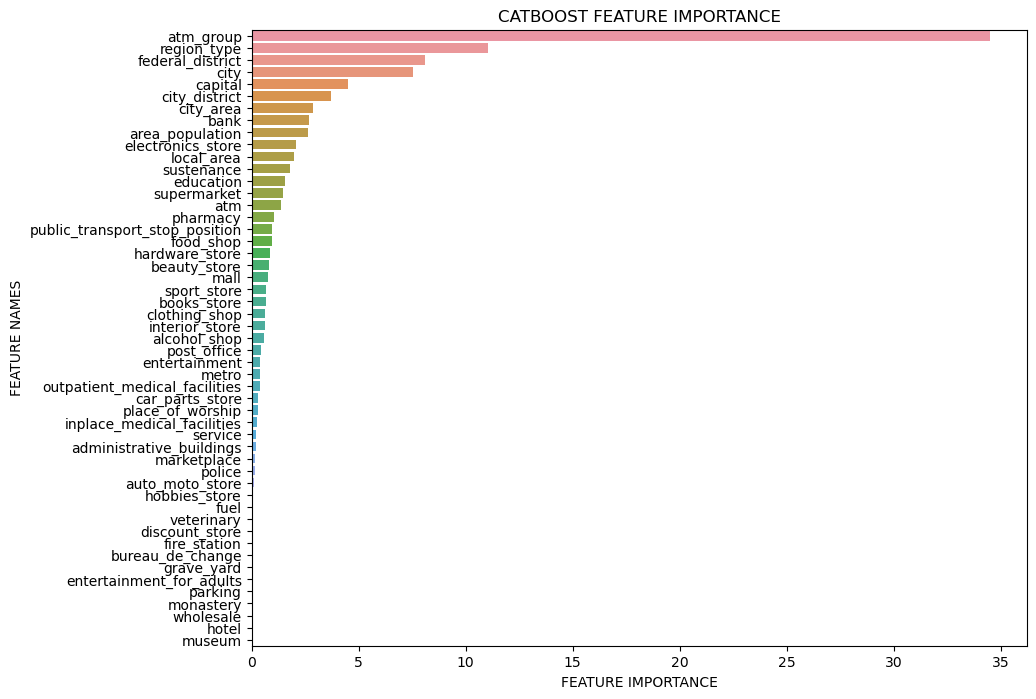

In [57]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
#plot the catboost result
plot_feature_importance(model.get_feature_importance(),X_train.columns,'CATBOOST ')

In [58]:
X_train['atm_group'].value_counts()

atm_group
5478.0    2117
1942.0     917
8083.0     849
496.5      495
3185.5     483
1022.0     108
32.0        37
Name: count, dtype: int64

In [36]:
X_train.columns

Index(['atm_group', 'city', 'city_area', 'city_district', 'metro',
       'federal_district', 'region_type', 'capital', 'local_area',
       'area_population', 'sustenance', 'education', 'fuel', 'service',
       'parking', 'atm', 'bank', 'bureau_de_change',
       'outpatient_medical_facilities', 'inplace_medical_facilities',
       'pharmacy', 'veterinary', 'entertainment', 'entertainment_for_adults',
       'administrative_buildings', 'police', 'fire_station', 'post_office',
       'grave_yard', 'marketplace', 'monastery', 'place_of_worship',
       'public_transport_stop_position', 'alcohol_shop', 'food_shop',
       'supermarket', 'mall', 'wholesale', 'clothing_shop', 'discount_store',
       'beauty_store', 'hardware_store', 'interior_store', 'electronics_store',
       'sport_store', 'auto_moto_store', 'car_parts_store', 'hobbies_store',
       'books_store', 'hotel', 'museum'],
      dtype='object')

In [24]:
def get_area_features(df:pd.DataFrame) -> pd.DataFrame:
    addresses = []
    cities, city_areas, city_district, federal_district  = [], [], [], []

    geolocator = Nominatim(user_agent='your_app_name')
    coordinates = np.array([list(df.loc[idx][['lat', 'long']].tolist()) for idx in range(len(df))])
    
    for coordinate in coordinates:
        addresses.append(geolocator.reverse(coordinate))

    for add in addresses:
        try:
            cities.append(add.raw['address']['city'])
        except:
            cities.append('')
        try:
            city_areas.append(add.raw['address']['county'])
        except:
            city_areas.append('')
        try:
            city_district.append(add.raw['address']['quarter'])
        except:
            city_district.append('')
        try:
            federal_district.append(add.raw['address']['state'])
        except:
            federal_district.append('')

        df['city'] = cities
        df['city_area'] = city_areas
        df['city_district'] = city_district
        df['federal_district'] = federal_district

        return df

In [108]:
lat = [55.805827]
long = [37.515146]

# lat = [54.783011]
# long = [73.720413]

test_df = pd.DataFrame({'lat':lat, "long":long})

In [109]:
get_area_features(test_df)

,lat,long,city,city_area,city_district,federal_district
0,55.805827,37.515146,Москва,,,Москва


In [110]:
def get_objects(tags:list, df:pd.DataFrame, flag:bool = False) -> pd.DataFrame:
    if flag:
        col_names = []

        for idx in range(len(tags)):
            col = list(tags[idx].values())[0]
            col_names.append(col)
            col_names.append('id')
        
        dfs = []
        df_tmp = pd.DataFrame(columns=col_names)

        for idx in range(len(df)):
            point = df.loc[idx][['lat', 'long']].tolist()
            df_tmp.loc[0, 'id'] = df.loc[idx]['id']
            for tag in tags:
                try:
                    geodf = ox.features_from_point(
                        center_point=point,
                        tags=tag,
                        dist=100
                        ).reset_index()
                    df_tmp.loc[0, list(tag.values())[0]] = len(geodf)
                except:
                    df_tmp.loc[0, list(tag.values())[0]] = 0

            df_tmp = df_tmp.loc[:,~df_tmp.columns.duplicated()]
            dfs.append(df_tmp)
            df_final = pd.concat(dfs)
            df_final = pd.merge(df, df_final, on=['id'])

        return df_final       
    
    else:
        col_names = []

        for idx in range(len(tags)):
            col = list(tags[idx].values())[0]
            col_names.append(col)
            col_names.append('lat')
            col_names.append('long')

        df_final = pd.DataFrame(columns=col_names)

        for idx in range(len(df)):
            point = df.loc[idx][['lat', 'long']].tolist()
            df_final.loc[0, 'lat'] = point[0]
            df_final.loc[0, 'long'] = point[1]
            for tag in tags:
                try:
                    geodf = ox.features_from_point(
                        center_point=point,
                        tags=tag,
                        dist=100
                        ).reset_index()
                    df_final.loc[0, list(tag.values())[0]] = len(geodf)
                except:
                    df_final.loc[0, list(tag.values())[0]] = 0
            
            df_final = df_final.loc[:,~df_final.columns.duplicated()]

        return df_final

In [111]:
test_df

,lat,long,city,city_area,city_district,federal_district
0,55.805827,37.515146,Москва,,,Москва


In [112]:
with open('objects.json') as json_file:
    data = json.load(json_file)

In [115]:
get_objects(data, df_train[:5], flag=True)

,id,atm_group,address,address_rus,lat,long,target,fast_food,cafe,bar,...,retail,supermarket,warehouse,religious,church,government,station,tram,platform,administrative
0,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710,0,0,0,...,0,2,0,0,0,0,0,0,1,0
1,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035,6,1,0,...,1,0,0,0,0,0,1,0,4,3
3,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277,0,1,0,...,2,0,0,0,0,0,0,0,4,2
4,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277,0,1,0,...,2,0,0,0,0,0,0,0,4,2


In [ ]:
cols_to_use = ['area_population', 'capital', 'metro', ]

In [32]:
df_trai['local_area']

0        901.401980
1        207.740736
2        207.740736
3          4.655655
4       4511.953383
           ...     
6256     144.141162
6257     426.401210
6258      12.189196
6259       9.730076
6260      43.691843
Name: local_area, Length: 6261, dtype: float64

In [23]:
cols_to_use = df_trai.columns.difference(full_test_df.columns)
cols_to_use

Index(['administrative_buildings', 'alcohol_shop', 'area_population',
       'auto_moto_store', 'beauty_store', 'books_store', 'capital',
       'car_parts_store', 'city', 'city_area', 'city_district',
       'clothing_shop', 'discount_store', 'education', 'electronics_store',
       'entertainment', 'entertainment_for_adults', 'federal_district',
       'fire_station', 'food_shop', 'grave_yard', 'hardware_store',
       'hobbies_store', 'inplace_medical_facilities', 'interior_store',
       'local_area', 'mall', 'metro', 'monastery', 'museum',
       'outpatient_medical_facilities', 'place_of_worship',
       'public_transport_stop_position', 'region_type', 'service',
       'sport_store', 'sustenance', 'veterinary', 'wholesale'],
      dtype='object')

In [21]:
cols_to_use = df_trai.columns.difference(full_test_df.columns)

pd.merge(full_test_df, df_trai[cols_to_use], left_index=True, right_index=True, how='outer')

,id,atm_group,address,address_rus,lat,long,target,fast_food,cafe,bar,...,museum,outpatient_medical_facilities,place_of_worship,public_transport_stop_position,region_type,service,sport_store,sustenance,veterinary,wholesale
0,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710,0,0,0,...,0.0,0.0,0.0,0.0,Сахалинская обл,0.0,0.0,0.0,0.0,0.0
1,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540,0,0,0,...,0.0,0.0,0.0,0.0,Сахалинская обл,0.0,0.0,0.0,0.0,0.0
2,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035,6,1,0,...,0.0,0.0,0.0,0.0,Сахалинская обл,0.0,0.0,0.0,0.0,0.0
3,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277,0,1,0,...,0.0,2.0,0.0,7.0,г Москва,0.0,0.0,12.0,0.0,0.0
4,313.0,32.0,"RUSSKAYA, 16 VLADIVOSTOK","Русская улица, 16, Владивосток, Приморский кра...",43.165860,131.908212,-0.145001,0,2,0,...,0.0,0.0,0.0,6.0,Красноярский край,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,Респ Саха /Якутия/,0.0,1.0,0.0,0.0,0.0
6257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,Кемеровская область - Кузбасс,0.0,0.0,0.0,0.0,0.0
6258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,г Москва,0.0,1.0,5.0,0.0,0.0
6259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,Томская обл,0.0,0.0,0.0,0.0,0.0


In [86]:
def get_population(df:pd.DataFrame) -> pd.DataFrame:
    
    houses = ['semidetached_house', 'terrace', 'detached', 'house']
    apartments = ['apartments' , 'dormitory']

    all_populations = []
    
    for idx in range(len(df)):
        try:
            population_resp = ox.features_from_point(center_point=df.iloc[idx][['lat', 'long']].tolist(), 
                       tags={'building' : [
                           'apartments' , 'dormitory','house', 'semidetached_house', 
                           'detached', 'terrace', 
                           ]}, dist=200).reset_index().fillna(1)
            
            population = (sum([int(x)*10*3 for x in population_resp[population_resp['building']
                                                                    .isin(apartments)]['building:levels'].tolist()])) + \
                         (sum([int(x)*3 for x in population_resp[population_resp['building']
                                                                 .isin(houses)]['building:levels'].tolist()]))

            all_populations.append(population)
        except:
            all_populations.append(0)

    df['population'] = all_populations

    return df

In [87]:
get_population(df_train[:10])

/var/folders/wt/dr3521jx3dlf8ys18db161rc0000gn/T/ipykernel_2451/925148896.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['population'] = all_populations


,id,atm_group,address,address_rus,lat,long,target,population
0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500,1992
1,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710,4680
2,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540,312
3,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035,6990
4,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277,3420
5,313.0,32.0,"RUSSKAYA, 16 VLADIVOSTOK","Русская улица, 16, Владивосток, Приморский кра...",43.165860,131.908212,-0.145001,1260
6,335.0,32.0,"SHUKHOVA, 14 MOSCOW","улица Шухова, 14, Москва, Россия, 115162",55.716859,37.613063,-0.024682,3630
7,358.0,32.0,"ADMIRALA FOKINA, 25 VLADIVOSTOK","улица Адмирала Фокина, 25, Владивосток, Примор...",43.117174,131.885503,-0.133426,2730
8,2895.0,32.0,Zhivopisnaia 136 d.Velednikov,"деревня Веледниково, городской округ Истра, Мо...",55.799765,37.116016,0.141469,0
9,1975.0,496.5,BEKESHSKAYA 39 PENZA,"Бекешская улица, 39, Пенза, Россия, 440018",53.203220,44.978826,0.017259,381


In [82]:
population_resp = ox.features_from_point(center_point=test_df.iloc[0][['lat', 'long']].tolist(), 
                       tags={'building' : [
                           'apartments' , 'dormitory','house', 'semidetached_house', 
                           'detached', 'terrace', 
                           ]}, dist=500).reset_index().fillna(1)

InsufficientResponseError: No data elements in server response. Check log and query location/tags.

In [70]:
population_resp.head(3)

,element_type,osmid,geometry,nodes,addr:housenumber,addr:street,building,building:levels,addr2:housenumber,addr2:street,abandoned,addr:city,ways,type
0,way,38536625,"POLYGON ((44.98543 53.20529, 44.98503 53.20446...","[456042155, 456042156, 456042157, 4311251643, ...",182,улица Суворова,apartments,5,1,1,1,1,1,1
1,way,38536627,"POLYGON ((44.98470 53.20427, 44.98413 53.20437...","[456042159, 4319789708, 4319789699, 4349609267...",184,улица Суворова,apartments,5,1,1,1,1,1,1
2,way,38536912,"POLYGON ((44.98585 53.20605, 44.98625 53.20688...","[456043661, 456043662, 456043663, 4417903278, ...",178,улица Суворова,apartments,5,1,1,1,1,1,1


In [68]:
apartments = ['apartments' , 'dormitory']
houses = ['house', 'semidetached_house', 'detached', 'terrace']

In [74]:
sum([int(x)*10*3 for x in population_resp[population_resp['building'].isin(apartments)]['building:levels'].tolist()])

4140

In [75]:
sum([int(x)*3 for x in population_resp[population_resp['building'].isin(houses)]['building:levels'].tolist()])

921

In [83]:
%%time

col_names = []

for idx in range(len(data)):
    col = list(data[idx].values())[0]
    col_names.append(col)

gdfs = []
for idx in range(len(test_df)):
    point = tuple(test_df.loc[idx][['lat', 'long']].tolist())
    city = test_df.loc[idx]['city']
    for tag in data:
        gdfs.append(get_obj(get_area_features(test_df), tag=tag, city=city))

CPU times: user 1.41 s, sys: 71.9 ms, total: 1.48 s
Wall time: 29 s


In [84]:
data_poi = pd.concat(gdfs)

In [85]:
data_poi_agg = data_poi.groupby(['point','object','type'], as_index = False).agg({'geometry':'count'})

In [86]:
pd.pivot_table(data_poi_agg, index=["point"], columns=['type'], aggfunc=[np.sum], values=['geometry']).reset_index()

/var/folders/wt/dr3521jx3dlf8ys18db161rc0000gn/T/ipykernel_1049/3634488213.py:1: FutureWarning: The provided callable <function sum at 0x1139c28c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pd.pivot_table(data_poi_agg, index=["point"], columns=['type'], aggfunc=[np.sum], values=['geometry']).reset_index()


point                  sum  \
                                                                    geometry   
type                                                    apartments, detached   
0             lat       long  city            city_a...                    0   

                                                                     \
                                                                      
type atm bank bar bicycle_parking bureau_de_change bus_station cafe   
0      0    0   0               0                0           0    0   

                  ...                                                         \
                  ...                                                          
type car_sharing  ... social_centre social_facility supermarket taxi theatre   
0              0  ...             0               0           0    0       0   

                                                         
                                                         
type toilets traffic_park training university warehouse  
0          0            0        0          0         0  

[1 rows x 57 columns]

In [87]:
data_poi_agg

,point,object,type,geometry
0,lat long city city_a...,amenity,atm,0
1,lat long city city_a...,amenity,bank,0
2,lat long city city_a...,amenity,bar,0
3,lat long city city_a...,amenity,bicycle_parking,0
4,lat long city city_a...,amenity,bureau_de_change,0
5,lat long city city_a...,amenity,bus_station,0
6,lat long city city_a...,amenity,cafe,0
7,lat long city city_a...,amenity,car_sharing,0
8,lat long city city_a...,amenity,cinema,0
9,lat long city city_a...,amenity,clinic,0


In [121]:
test_df

,lat,long,city,city_areas,city_district,federal_district
0,0.0,0.0,0,0,0,0


In [120]:
test_df.iloc[0] = 0

In [21]:
df.reset_index(drop=True, inplace=True)

df_train_val = df.drop(['id', 'address', 'address_rus', 'lat', 'long','target'], axis=1)
y_train_val = df['target']
X_train, X_test, y_train, y_test = tts(pd.concat([pd.get_dummies(df_train_val[cat_features]), df_train_val[num_features]], axis=1), y_train_val, shuffle=True, stratify=y_train_val, train_size=0.8)

In [22]:
model = LinearRegression()

model.fit(X_train, y_train)
predicts = model.predict(X_test)

In [23]:
mean_absolute_error(y_test, predicts)

0.4909786184644647

In [24]:
model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)
predicts = model.predict(X_test)

/usr/local/Caskroom/miniconda/base/envs/diplom/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
from sklearn.metrics import f1_score

f1_score(y_test, predicts, average='micro')

0.4504792332268371